In [11]:
import numpy as np
from scipy import ndimage, fft, stats
from matplotlib import pyplot as plt
from matplotlib.pyplot import imread

In [12]:
PLOT_RESULTS = True
RADIUS = 30
STD = 5
DPI=120

## 1.1 Fourier transformation

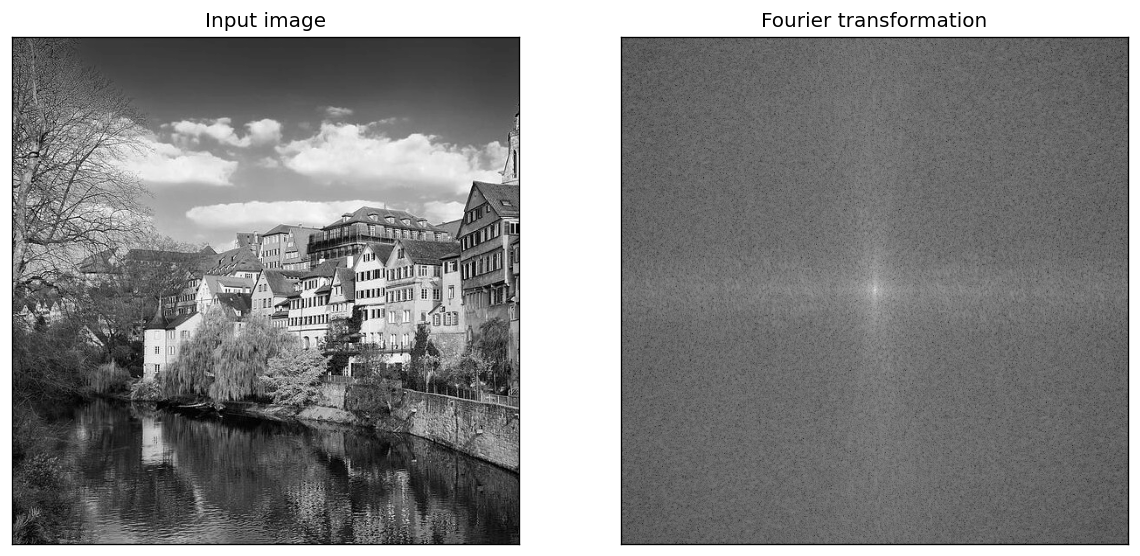

In [13]:
# ----- load the input image
img = imread('inputs/tuebingen.jpg')[:, :, 1] / 255.  
img_size = img.shape[0]


# TODO

FT_img_log = np.log(np.abs(fft.fftshift(fft.fft2(img))))
FT_img_nolog = fft.fftshift(fft.fft2(img))


# ----- plot input image together with fourier transformation
if PLOT_RESULTS:   #plot_results:
    plt.figure(figsize=(12, 12),dpi=DPI)
    plt.subplot(121)
    plt.xticks([]), plt.yticks([])
    plt.imshow(img, cmap = 'gray')
    plt.title('Input image')

    plt.subplot(122)
    plt.xticks([]), plt.yticks([])
    plt.imshow(FT_img_log, cmap='gray')
    plt.title('Fourier transformation')
    plt.show()
    

## 1.2 High-pass filter in spectral space

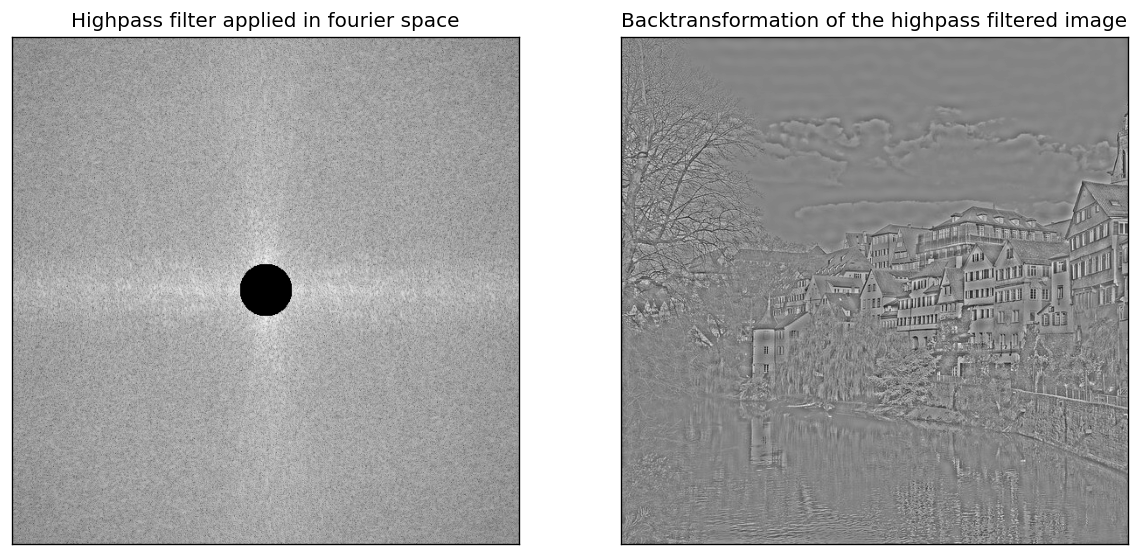

In [14]:
# TODO
def highpass_filter(img_size, radius):
    ''' Returns a highpass filter.
    input:
        img_size: length of the filter
        redius: radius of the circular aperture
    output:
        highpass: a filter of size(img_size, img_size) with values zero and one
    '''
    center = (img_size - 1) / 2
    x, y = np.meshgrid(np.arange(img_size), np.arange(img_size))
    dist = ((x - center)**2 + (y - center)**2)**0.5
    highpass = np.ones((img_size, img_size))
    highpass[dist < radius] = 0
    return highpass

# TODO

#   step 2: apply filter (with radius 30) to the spectrum
highpass = highpass_filter(img_size, radius=RADIUS)
img_highpass = np.where(highpass == 1, FT_img_nolog, 0)


# TODO
#   step 3: transform the spectrum back to image space                     
img_filtered = np.real(fft.ifft2(fft.ifftshift(img_highpass)))


if PLOT_RESULTS:   #plot_results:
    plt.figure(figsize=(12, 12),dpi=DPI)
    plt.subplot(121)
    plt.xticks([]), plt.yticks([])
    plt.imshow(np.abs(img_highpass)**0.15, cmap = 'gray')   # Potenz dient der Kontrastanpassung
    plt.title('Highpass filter applied in fourier space')

    plt.subplot(122)
    plt.xticks([]), plt.yticks([])
    plt.imshow((img_filtered), cmap=plt.cm.gray)
    plt.title('Backtransformation of the highpass filtered image')
    plt.show()


## 1.3 Gaussian filter

### 1.3.1 Construct a Gaussian filter

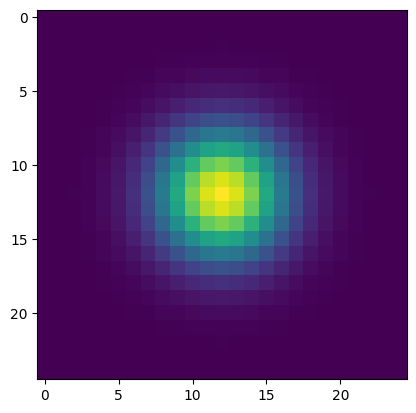

In [65]:
# TODO
def g_kern(kernlen=5, std=1):
    ''' Returns a 2D Gaussian kernel with standard devitation sig
    input:
        kernlen: length of the filter
        std: standard deviation of the gaussian in pixels
    output:
        g_kern_2d: a gaussian kernel of size (kernlen, kernlen) with sum 1
    '''
    #define center of the kernel
    centre = (kernlen - 1) / 2
    # define grid
    arr = np.arange((-kernlen//2),(kernlen//2)+1)

    x , y = np.meshgrid(arr + 0.5 , arr + 0.5)


    # Calculate the 2D Gaussian kernel
    g_kern_2d = stats.norm.cdf(x, scale=std) * stats.norm.cdf(y, scale=std)
    g_kern_2d = np.diff(g_kern_2d, axis=0)
    g_kern_2d = np.diff(g_kern_2d, axis=1)
    
    # Normalize the kernel
    g_kern_2d /= np.sum(g_kern_2d)

    return g_kern_2d

plt.imshow(g_kern(kernlen=25, std=3))



### 1.3.2 Apply Gaussian filter in image space

In [66]:
# TODO
#   step 2: create such a gaussian filter with standard deviation 3 and filtersize 25 and
#           convolve the image with this filter 
gaussfilter_img = g_kern(25, 3)
img_conv = ndimage.convolve(img, gaussfilter_img)
gaussfilter_img = np.pad(gaussfilter_img, (img_size - 25)//2, 'constant', constant_values=(0, 0))

### 1.3.3 Transform the Gaussian filter to fourier space

In [67]:
# TODO
#   step 3: transform the gaussian kernel to fourier space
gaussfilter_f = fft.fft2(gaussfilter_img)
gaussfilter_f_shift = fft.fftshift(gaussfilter_f)

### 1.3.4 Apply this filter in fourier space

In [68]:
#apply the gaussian filter in fourier space
f_gauss = FT_img_nolog * np.abs(gaussfilter_f_shift) # BUG does not really work 
img_gauss_f = np.abs(fft.ifft2(fft.ifftshift(f_gauss)))

### 1.3.5. Visuallise and compare two filtering methods

difference: 0.001256048714241181


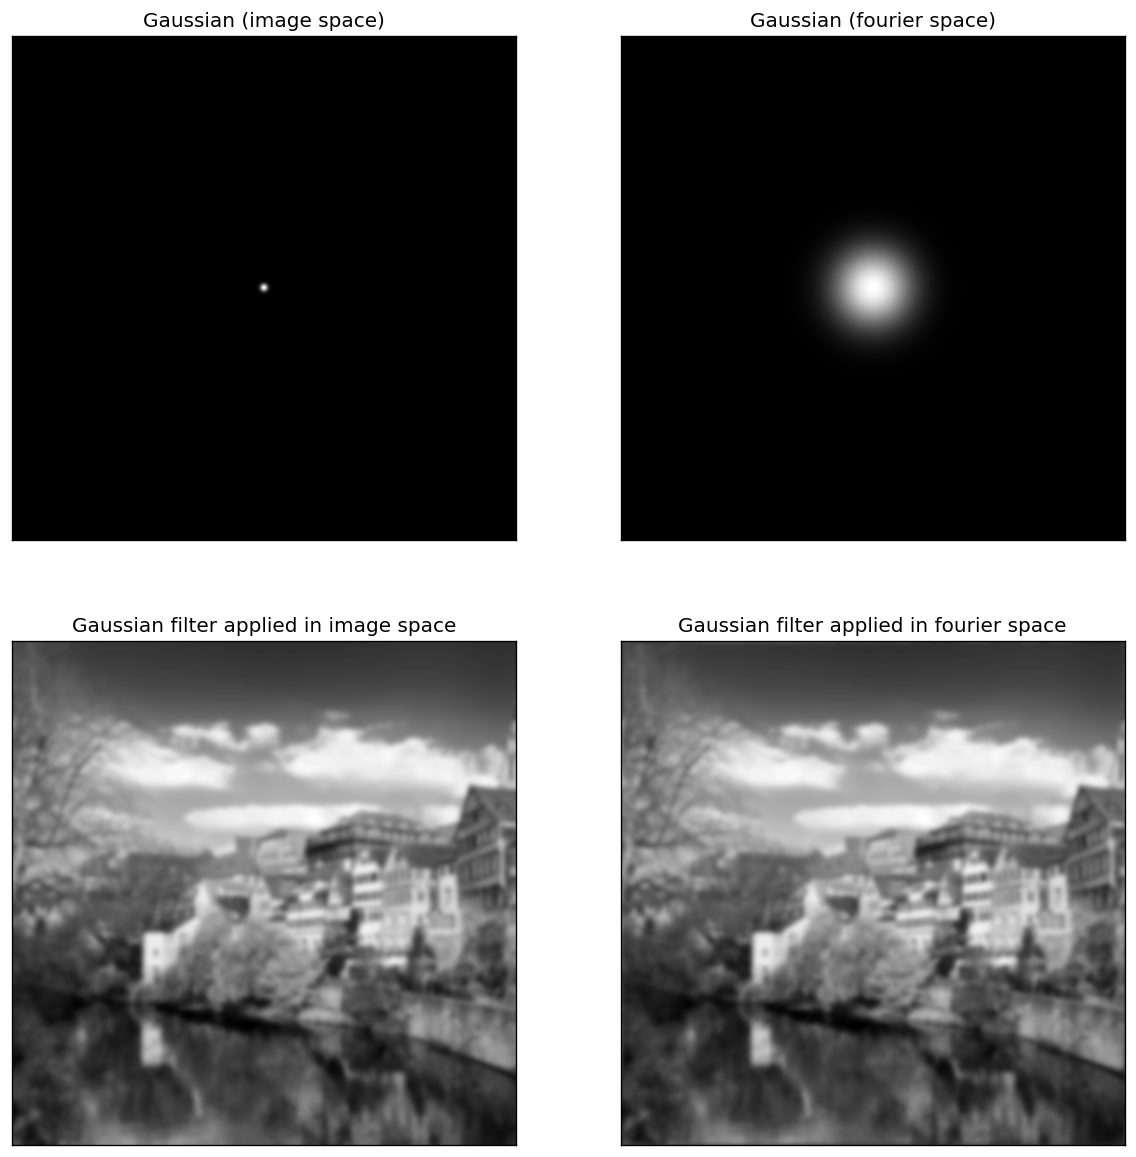

In [69]:
#   step 5: compare the results
difference = np.mean(np.abs(img_gauss_f - img_conv))       
print('difference: ' + str(difference))

if PLOT_RESULTS:
    # compare the two images
    plt.figure(figsize=(12, 12),dpi=DPI)

    plt.subplot(221)        # plt.subplot(122)
    plt.xticks([]), plt.yticks([])
    plt.imshow((gaussfilter_img), cmap=plt.cm.gray)
    plt.title('Gaussian (image space)')

    plt.subplot(222)        # plt.subplot(121)
    plt.xticks([]), plt.yticks([])
    plt.imshow(np.abs(gaussfilter_f_shift), cmap=plt.cm.gray)
    plt.title('Gaussian (fourier space)')

    plt.subplot(223)        # plt.subplot(122)
    plt.xticks([]), plt.yticks([])
    plt.imshow((img_conv), cmap=plt.cm.gray)      # img_conv
    plt.title('Gaussian filter applied in image space')

    plt.subplot(224)        # plt.subplot(121)
    plt.xticks([]), plt.yticks([])
    plt.imshow((img_gauss_f), cmap=plt.cm.gray)
    plt.title('Gaussian filter applied in fourier space')

    plt.show()

### 1.3.6 Splitted convolutional filter

In [33]:
# TODO
def g_kern1d(kernlen=5, std=1):
    '''
    Returns a 1D Gaussian kernel with standard devitation sig 
    input:
        kernlen: length of the filter std: standard deviation of the gaussian in  pixels 
    output: 
        g_kern_1d: a gaussian kernel of size (kernlen, 1)
    '''
    g_kern_1d = stats.norm.cdf(np.arange(kernlen), kernlen//2, std) - stats.norm.cdf(np.arange(kernlen), kernlen//2, std - 1)
    return g_kern_1d

gaussfilter_img_1D = g_kern1d(25, 3)
img_conv_sep_final = ndimage.convolve(img_conv, gaussfilter_img_1D)

# ----- plot results
if PLOT_RESULTS:   #plot_results:
    plt.figure(figsize=(12, 12),dpi=DPI)
    plt.subplot(121)
    plt.xticks([]), plt.yticks([])
    plt.imshow((img_conv), cmap=plt.cm.gray)      
    plt.title('Gaussian filter (2D) applied in image space')
    plt.subplot(122)
    plt.xticks([]), plt.yticks([])
    plt.imshow(img_conv_sep_final, cmap='gray')
    plt.title('Gaussian filter (separated) applied in image space')
    plt.show()

RuntimeError: filter weights array has incorrect shape.